<a href="https://colab.research.google.com/github/JohnAntonusMaximus/ensemble-training-advanced-regression/blob/master/Ensemble_Modeling_w_Advanced_Regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

# Read the data from input

train = pd.read_csv('./train.csv')
test = pd.read_csv('./test.csv')

# Any results you write to the current directory are saved as output.
train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,...,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,...,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,...,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,...,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,...,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,...,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


## Check Data Types

In [3]:
print(train.dtypes)

Id                 int64
MSSubClass         int64
MSZoning          object
LotFrontage      float64
LotArea            int64
Street            object
Alley             object
LotShape          object
LandContour       object
Utilities         object
LotConfig         object
LandSlope         object
Neighborhood      object
Condition1        object
Condition2        object
BldgType          object
HouseStyle        object
OverallQual        int64
OverallCond        int64
YearBuilt          int64
YearRemodAdd       int64
RoofStyle         object
RoofMatl          object
Exterior1st       object
Exterior2nd       object
MasVnrType        object
MasVnrArea       float64
ExterQual         object
ExterCond         object
Foundation        object
                  ...   
BedroomAbvGr       int64
KitchenAbvGr       int64
KitchenQual       object
TotRmsAbvGrd       int64
Functional        object
Fireplaces         int64
FireplaceQu       object
GarageType        object
GarageYrBlt      float64


### Check what is in object

In [4]:
print(train['SaleCondition'].unique())

['Normal' 'Abnorml' 'Partial' 'AdjLand' 'Alloca' 'Family']


### Assign numerics to catregorical labels

In [5]:
# string labels to categorical values
from sklearn.preprocessing import LabelEncoder

for i in range(train.shape[1]):
    if train.iloc[:,i].dtypes == object:
        lbl = LabelEncoder()
        lbl.fit(list(train.iloc[:,i].values) + list(test.iloc[:,i].values))
        train.iloc[:,i] = lbl.transform(list(train.iloc[:,i].values))
        test.iloc[:,i] = lbl.transform(list(test.iloc[:,i].values))

print(train['SaleCondition'].unique())

[4 0 5 1 2 3]


## Visualize all the missing data, the white lines are missing values

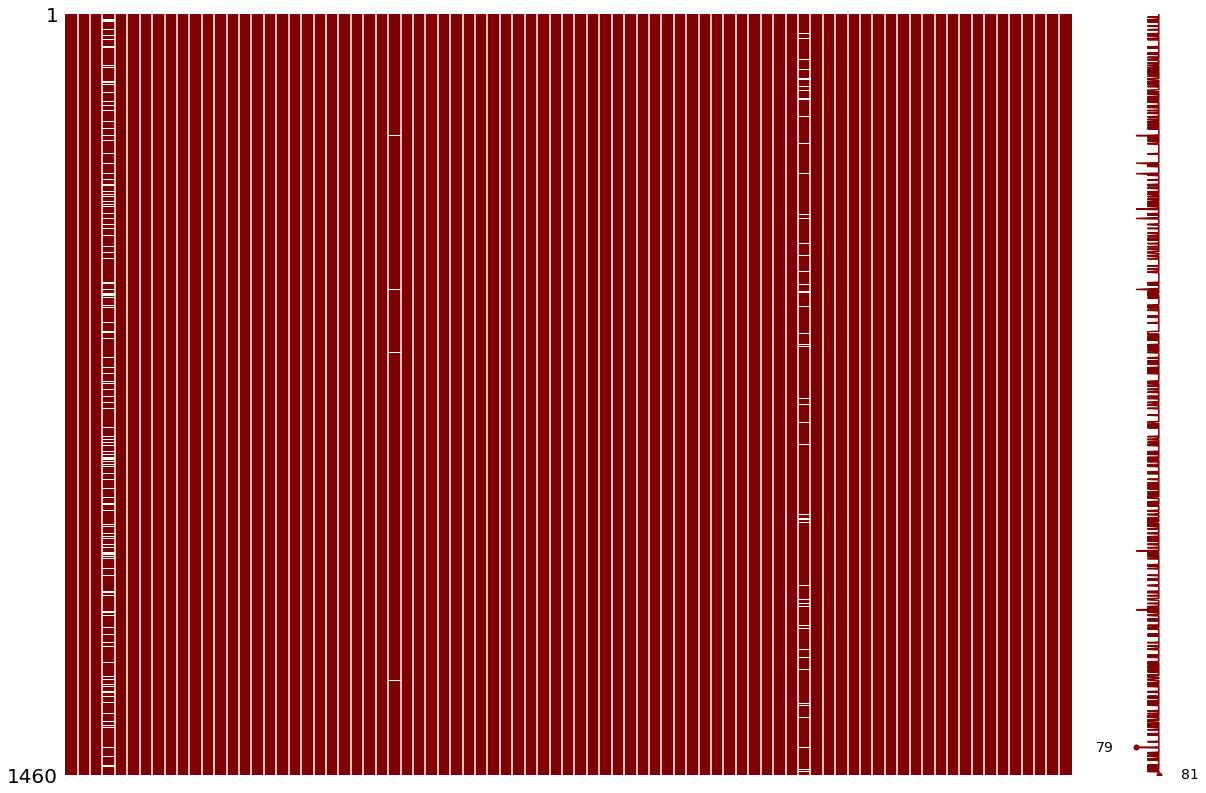

In [6]:
# search for missing data
import missingno as msno
msno.matrix(df=train, figsize=(20,14), color=(0.5,0,0))

### Which columns have missing values?

In [7]:
print('Training data+++++++++++')
for i in np.arange(train.shape[1]):
    n = train.iloc[:,i].isnull().sum()
    if n > 0:
        print(list(train.columns.values)[i] + ': ' + str(n) + ' nans')

print('Testing data+++++++++++')
for i in np.arange(test.shape[1]):
    n = test.iloc[:,i].isnull().sum()
    if n > 0:
        print(list(test.columns.values)[i] + ": " +str(n) + ' nans')

Training data+++++++++++
LotFrontage: 259 nans
MasVnrArea: 8 nans
GarageYrBlt: 81 nans
Testing data+++++++++++
LotFrontage: 227 nans
MasVnrArea: 15 nans
BsmtFinSF1: 1 nans
BsmtFinSF2: 1 nans
BsmtUnfSF: 1 nans
TotalBsmtSF: 1 nans
BsmtFullBath: 2 nans
BsmtHalfBath: 2 nans
GarageYrBlt: 78 nans
GarageCars: 1 nans
GarageArea: 1 nans


### Let's filling the missing data with the median value and drop feature columns with lots of missing data

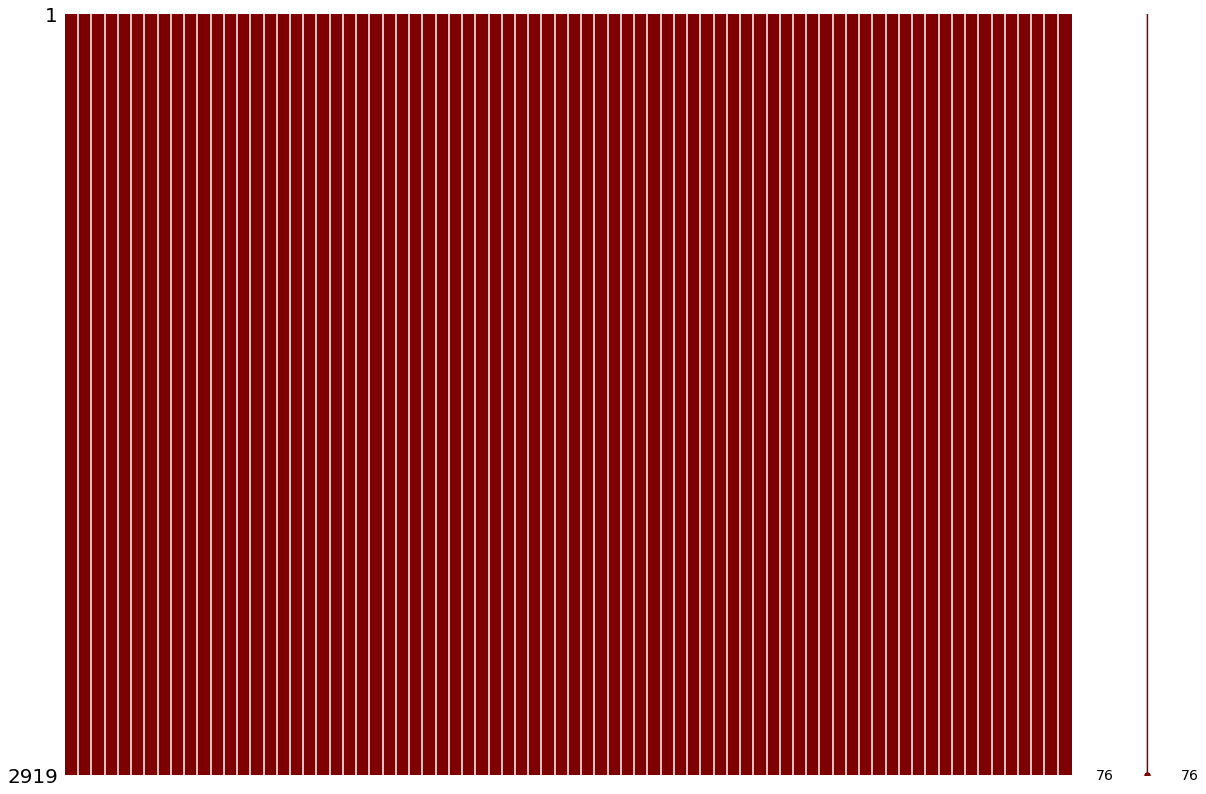

In [8]:
train_ID = train['Id']
test_ID = test['Id']

# split the data for training
y_train = train['SalePrice']
X_train = train.drop(['Id', 'SalePrice'], axis=1)
X_test = test.drop('Id', axis=1)

# Drop the columns with the largest missing data, fill spotted missing with median values
Xmat = pd.concat([X_train, X_test])
Xmat =Xmat.drop(['LotFrontage', 'MasVnrArea', 'GarageYrBlt'], axis =1)
Xmat = Xmat.fillna(Xmat.median())

# Visualize again
import missingno as msno
msno.matrix(df=Xmat, figsize=(20,14), color=(0.5,0,0))

In [9]:
print(Xmat.columns.values)
print(str(Xmat.shape[1]) + ' columns')

['MSSubClass' 'MSZoning' 'LotArea' 'Street' 'Alley' 'LotShape'
 'LandContour' 'Utilities' 'LotConfig' 'LandSlope' 'Neighborhood'
 'Condition1' 'Condition2' 'BldgType' 'HouseStyle' 'OverallQual'
 'OverallCond' 'YearBuilt' 'YearRemodAdd' 'RoofStyle' 'RoofMatl'
 'Exterior1st' 'Exterior2nd' 'MasVnrType' 'ExterQual' 'ExterCond'
 'Foundation' 'BsmtQual' 'BsmtCond' 'BsmtExposure' 'BsmtFinType1'
 'BsmtFinSF1' 'BsmtFinType2' 'BsmtFinSF2' 'BsmtUnfSF' 'TotalBsmtSF'
 'Heating' 'HeatingQC' 'CentralAir' 'Electrical' '1stFlrSF' '2ndFlrSF'
 'LowQualFinSF' 'GrLivArea' 'BsmtFullBath' 'BsmtHalfBath' 'FullBath'
 'HalfBath' 'BedroomAbvGr' 'KitchenAbvGr' 'KitchenQual' 'TotRmsAbvGrd'
 'Functional' 'Fireplaces' 'FireplaceQu' 'GarageType' 'GarageFinish'
 'GarageCars' 'GarageArea' 'GarageQual' 'GarageCond' 'PavedDrive'
 'WoodDeckSF' 'OpenPorchSF' 'EnclosedPorch' '3SsnPorch' 'ScreenPorch'
 'PoolArea' 'PoolQC' 'Fence' 'MiscFeature' 'MiscVal' 'MoSold' 'YrSold'
 'SaleType' 'SaleCondition']
76 columns


In [10]:
Xmat['TotalSF'] = Xmat['TotalBsmtSF'] + Xmat['1stFlrSF'] + Xmat['2ndFlrSF']
print('There are currently ' + str(Xmat.shape[1]) + ' columns.')

There are currently 77 columns.


### Check the target distribution

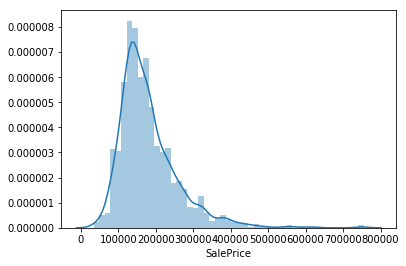

In [11]:
ax = sns.distplot(y_train)
plt.show()

### Our target label is skewed right, we need to normalize since this is regression

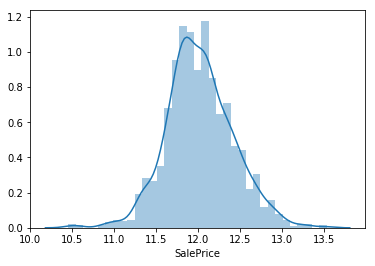

In [12]:
y_train = np.log(y_train)

ax = sns.distplot(y_train)
plt.show()

### Lets see the correlations between features

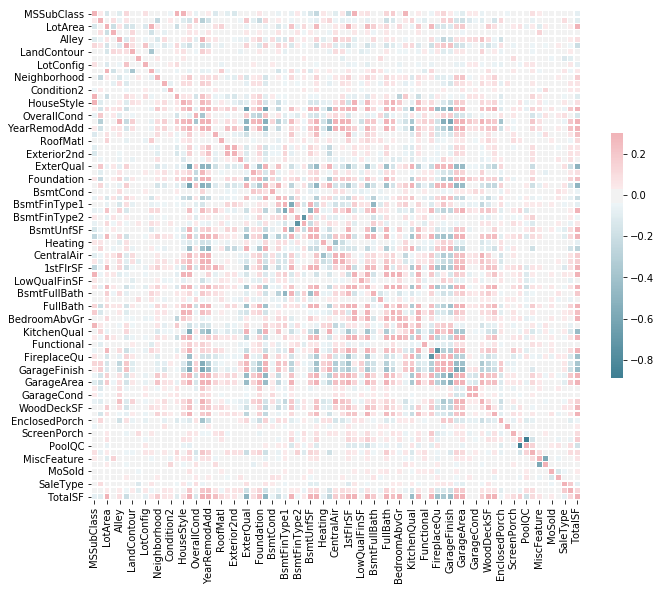

In [13]:
# Check the correlation matrix
X_train = Xmat.iloc[:train.shape[0],:]
X_test = Xmat.iloc[train.shape[0]:,:]

# Compute correlation matrix
corr = X_train.corr()

# Set up the correlation matrix
f, ax = plt.subplots(figsize=(11,9))

# Generate a custom diverging color map
cmap = sns.diverging_palette(220,10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, cmap=cmap, vmax=.3, center=0,
               square=True, linewidths=.5, cbar_kws={"shrink": .5})

plt.show()

### We can use a random forest regressor to tell us which features matter most

Training done using Random Forest


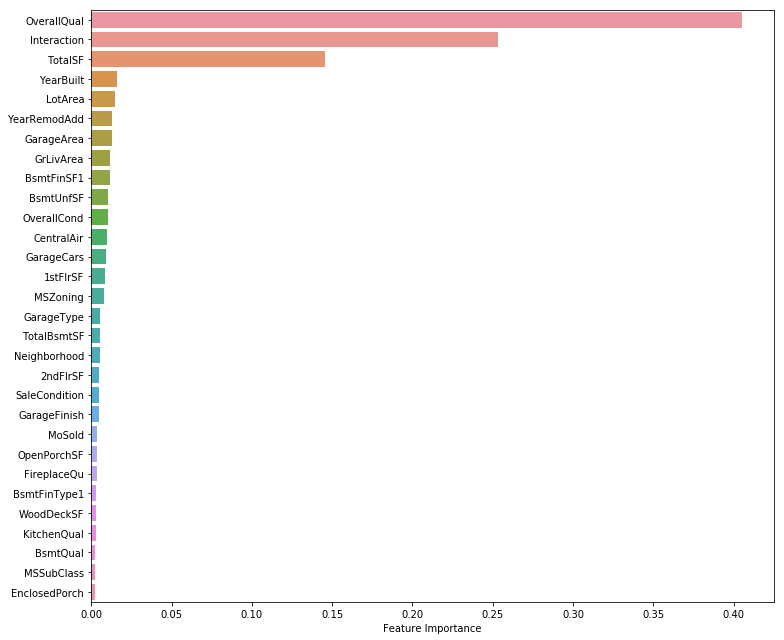

In [31]:
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor(n_estimators=80, max_features='auto')
rf.fit(X_train, y_train)
print("Training done using Random Forest")

ranking = np.argsort(-rf.feature_importances_)
f, ax = plt.subplots(figsize=(11,9))
sns.barplot(x=rf.feature_importances_[ranking], y=X_train.columns.values[ranking], orient='h')
ax.set_xlabel("Feature Importance")
plt.tight_layout()
plt.show()

### We'll use the top 30 features only for our learning models and create a new feature which describes the interaction of our top two features, called "Interaction"

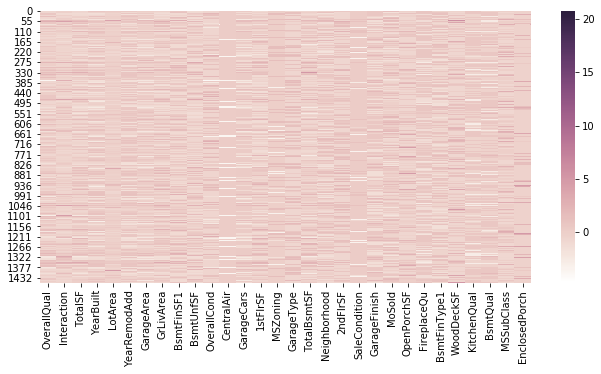

In [32]:
X_train = X_train.iloc[:,ranking[:30]]
X_test = X_test.iloc[:,ranking[:30]]


X_train["Interaction"] = X_train["TotalSF"]*X_train["OverallQual"]
X_test["Interaction"] = X_test["TotalSF"]*X_test["OverallQual"]



# We'll use z-scoring for our values to standardize the data
X_train = (X_train - X_train.mean())/X_train.std()
X_test = (X_test - X_test.mean())/X_test.std()
    
# heatmap
f, ax = plt.subplots(figsize=(11, 5))
cmap = sns.cubehelix_palette(light=1, as_cmap=True)
sns.heatmap(X_train, cmap=cmap)
plt.show()

### Check featuers for linearity and their importance towards Sale Price

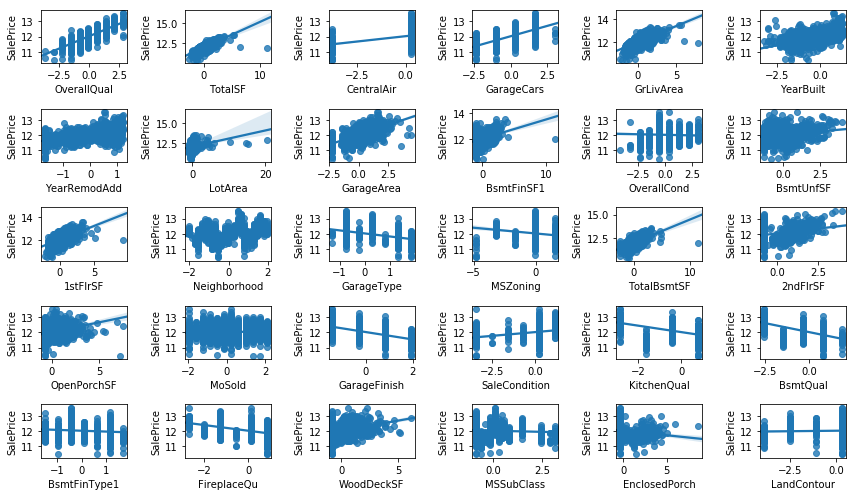

In [16]:
fig = plt.figure(figsize=(12,7))
for i in np.arange(30):
    ax = fig.add_subplot(5,6,i+1)
    sns.regplot(x=X_train.iloc[:,i], y=y_train)

plt.tight_layout()
plt.show()

### Let's delete the outliers

In [0]:
Xmat = X_train
Xmat['SalePrice'] = y_train
Xmat = Xmat.drop(Xmat[(Xmat['TotalSF']>5) & (Xmat['SalePrice']<12.5)].index)
Xmat = Xmat.drop(Xmat[(Xmat['GrLivArea']>5) & (Xmat['SalePrice']<13)].index)

# Make our training and test set ready for model analysis
y_train = Xmat['SalePrice']
X_train = Xmat.drop(['SalePrice'], axis=1)

### First we'll use XGBoost

In [18]:
import xgboost as xgb
from sklearn.model_selection import GridSearchCV

print("Parameter Optimization")
xgb_model = xgb.XGBRegressor()
reg_xgb = GridSearchCV(xgb_model,
                       {'max_depth': [2,4,6],
                       'n_estimators': [50,100,200]}, verbose=1)
reg_xgb.fit(X_train,y_train)
print(reg_xgb.best_score_)
print(reg_xgb.best_params_)

Parameter Optimization
Fitting 3 folds for each of 9 candidates, totalling 27 fits
[15:12:12] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is depr

[15:12:13] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:12:13] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:12:13] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[15:12:13] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:12:13] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[15:12:13] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[15:12:13] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[15:12:14] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[15:12:14] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:12:14] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:12:14] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[15:12:14] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:12:14] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[15:12:15] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:12:15] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[15:12:15] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[15:12:16] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[15:12:16] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:12:16] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[15:12:16] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:12:16] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[15:12:17] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[15:12:17] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[15:12:17] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[15:12:18] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[15:12:18] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[Parallel(n_jobs=1)]: Done  27 out of  27 | elapsed:    6.4s finished
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[15:12:19] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
0.9013804066104524
{'max_depth': 2, 'n_estimators': 200}


### Next our Neural Network using Tensorflow

In [19]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor

def create_model(optimizer='adam'):
    model = Sequential()
    model.add(Dense(X_train.shape[1], input_dim=X_train.shape[1], kernel_initializer='normal', activation='relu'))
    model.add(Dense(16, kernel_initializer='normal', activation='relu'))
    model.add(Dense(1, kernel_initializer='normal'))

    model.compile(loss='mean_squared_error', optimizer=optimizer)
    return model

model = KerasRegressor(build_fn=create_model, verbose=0)
# define the grid search parameters
optimizer = ['SGD','Adam']
batch_size = [10, 30, 50]
epochs = [10, 50, 100]
param_grid = dict(optimizer=optimizer, batch_size=batch_size, epochs=epochs)
reg_dl = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1)
reg_dl.fit(X_train, y_train)

print(reg_dl.best_score_)
print(reg_dl.best_params_)

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
W0814 15:14:24.358389 140317596292992 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/initializers.py:143: calling RandomNormal.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


-0.0298712628718532
{'batch_size': 10, 'epochs': 100, 'optimizer': 'SGD'}


### Finally a Support Vector Regressor

In [33]:
from sklearn.svm import SVR

reg_svr = GridSearchCV(SVR(kernel='rbf', gamma=0.1), cv=5,
                      param_grid={"C": [1e0, 1e1, 1e2, 1e3],
                                 "gamma": np.logspace(-2,2,5)})# 

reg_svr.fit(X_train, y_train)

print(reg_svr.best_score_)
print(reg_svr.best_params_)

0.9023038610419548
{'C': 1.0, 'gamma': 0.01}


## Let's put all our model predictions into a DataFrame

In [21]:
# second feature matrix
X_train2 = pd.DataFrame( {'XGB': reg_xgb.predict(X_train),
     'NN': reg_dl.predict(X_train).ravel(),
     'SVR': reg_svr.predict(X_train),
    })
X_train2.head()

,XGB,NN,SVR
0,12.234232,12.310159,12.212457
1,12.124506,12.189281,12.123729
2,12.257887,12.222080,12.262481
3,11.923144,11.906910,11.949181
4,12.589277,12.490048,12.544153


### Here we're going to use Ensemble Modeling. We're going to combine our models using a Linear Regressor to give us the weighted average of prediction accuracy. Models with higher accuracy will be given more weight. 

#### Since we're still using the data at logscale, we need to bring our predictions back to normal scale in the last line.

In [0]:
# second-feature modeling using linear regression
from sklearn import linear_model

reg = linear_model.LinearRegression()
reg.fit(X_train2, y_train)

# prediction using the test set
X_test2 = pd.DataFrame( {'XGB': reg_xgb.predict(X_test),
     'DL': reg_dl.predict(X_test).ravel(),
     'SVR': reg_svr.predict(X_test),
    })

# Non-log scale
y_pred = np.exp(reg.predict(X_test2))

In [37]:
# Final Predictions on home prices
submission = pd.DataFrame({
    "Id": test_ID,
    "SalePrice": y_pred
})
submission.to_csv('houseprice.csv', index=False)

## Show the first thirty sale price predictions along with the house ID
submission[:30]

,Id,SalePrice
0,1461,124803.743453
1,1462,162934.254780
2,1463,174202.314603
3,1464,195299.219307
4,1465,185948.689672
5,1466,172298.597308
6,1467,179356.645528
7,1468,165998.137707
8,1469,178016.658306
9,1470,125171.186085
